In [1]:
import sys
# import pyccl as ccl#
import pickle
#import camb
from classy import Class
import matplotlib.pyplot as plt
sys.path.insert(0,'/home/tkarim/SkyLens/') #path to skylens
sys.path.insert(0,'/home/tkarim/SkyLens/skylens/') #path to skylens
# from importlib import reload

In [2]:
#setting up virtual dask cluster for calculations. Adjust memory and threads according to your system.
from distributed import LocalCluster
from dask.distributed import Client 
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='150gb',threads_per_worker=4,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

In [3]:
from skylens import *
from survey_utils import *

In [4]:
#only for python3
import importlib
reload=importlib.reload

In [5]:
wigner_files={} #FIXME: run Gen_wig_m0.py to generate these files and then pass their path here. These are large files, make sure they are not included in git.
# In file names l3500 refers to ell_max for which wigner function was calculated. It should be same or larger than ell_max in your measurements. 
# |w2100 is the max ell for window. This should be atleast 2 X ell_max in the measurements.
wigner_files[0]= '../temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'

# wigner_files[2]= '/Users/Deep/dask_temp/dask_wig3j_l3500_w2100_2_reorder.zarr' #everything is spin 0, should not require this. if needed, compute using Gen_wig_m2.py



# Power Spectrum covariance

In [6]:
#set cosmology
cosmo_params = {'h': 0.6736,
 'Omb': 0.04930,
 'Omd': 0.26447,
 'Om': 0.31377,
 'Ase9': 2.083,
 'mnu': 0.06,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.9649,
 'alpha_s': 0.0,
 'N_ur': 2.0328,
 'N_ncdm': 1.0,
 'omega_ncdm': 0.0006442,
 'w': -1.0,
 'wa': 0.0,
 'Oml': 0.68623, #set manually
 'z_max': 2.45,
 'OmR': 0.}

In [66]:
test = False

if test:
    NSIDE = 256
    lmax_cl = 256
    binsize = 10
else:
    NSIDE = 1024
    lmax_cl = NSIDE
    binsize = 100

In [67]:
#setup parameters
#FIXME: Check all the values below.
#lmax_cl=1024 #min and max for ell
lmin_cl=100
l0=np.arange(lmin_cl,lmax_cl)

#following defines the ell bins. Using log bins in example, feel free to change.
lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=20
#l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
l_bins = np.arange(lmin_cl, lmax_cl, binsize)
#lb=np.sqrt(l_bins[1:]*l_bins[:-1])
lb=0.5*(l_bins[1:]+l_bins[:-1])

l=l0
# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if computation is too heavy and we want to use fewer ell

do_cov=False # if you want to get covariance. Covariance is slow and this should be false if you are calling skylens inside mcmc.
bin_cl=True #bin the theory and covaraince. 

use_window=True #if you want to include the window effect. Code will return pseudo-cl and pseudo-cl covariance
store_win=True # to store window, for some internal reasons. leave it to true.
window_lmax=2*lmax_cl #smaller value for testing. This should be 2X ell_max in the measurements.

use_binned_l=False  #FIXME: to speed up computation if using pseudo-cl inside mcmc. Needs to be tested. Leave it false for now.

SSV_cov=False # we donot have good model for super sample and tri-spectrum. We can chat about implementing some approximate analytical forms.
tidal_SSV_cov=False
Tri_cov=False 

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [68]:
def cmb_bins_here(zs=1090,l=None,use_window=use_window,unit_win=False,nside=1024,zmax=2.45):
    """
    unit_win = boolean mask 
    nside = 2048; same as sims
    This function prepares the cmb lensing data into format required for input into skylens for theory predictions.
    """
    zs_bins={}
    zs_bins[0]={}

    zs_bins=zbin_pz_norm(zs_bins=zs_bins,bin_indx=0,zs=np.atleast_1d(zs),p_zs=np.atleast_1d(1),
                         ns=0,bg1=1)
    zs_bins['n_bins']=1 #easy to remember the counts
    zs_bins['zmax']=np.atleast_1d([zmax])
    zs_bins['zp_sigma']=0
    zs_bins['zp_bias']=0
    zs_bins['nz']=1

    SN_read=np.genfromtxt('/mnt/store1/tkarim/cmb_lensing/data/MV/nlkk.dat',
                          names=('l','nl','nl2')) 
    SN_intp=interp1d(SN_read['l'],SN_read['nl'],bounds_error=False, fill_value=0)      #FIXME: make sure using the correct noise power spectra.
    SN=SN_intp(l)
    SN *= 0 #DON'T DO THIS WHEN USING REAL DATA
#     SN=np.ones_like(l)
    zs_bins['SN']={}
    zs_bins['SN']['kappa']=SN.reshape(len(SN),1,1)
    if use_window:
        zs_bins=set_window(zs_bins=zs_bins,nside=nside, unit_win=unit_win,cmb=True)
    return zs_bins

In [69]:
def set_window(zs_bins={},nside=1024,mask=None,window_cl_fact=None,unit_win=False,cmb=False):
    """
        This function sets the window functions for the datasets. These windows are necessary for converting cl to pseudo-cl.
    """
    #FIXME: make sure nside, etc. are properly matched. if possible, use same nside for cmb and galaxy maps. Use ud_grade where necessary.
    for i in np.arange(zs_bins['n_bins']):
        if unit_win:
            cl_map=hp.ma(np.ones(12*nside*nside))
            cl_i=1
        elif cmb:
            #cl_map=np.load('/mnt/store1/tkarim/mask_2048.fits') #FIXME: add the CMB lensing window here.
            cl_map=np.load('/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_ring_2048.npy')
            noise_map = cl_map
            #mask = cl_map
        else:
            #cl_map=np.load('/mnt/store1/tkarim/cmb_lensing/data/dr8/elg_ran1024.npy') #randoms are the window function.
            cl_map=np.load('/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_ring_2048.npy') #randoms are the window function.
            noise_map = np.sqrt(cl_map)
        cl_map = cl_map.astype(np.float64)
        cl_map=hp.ma(cl_map)
        noise_map = hp.ma(noise_map)
#             cl_map=hp.alm2map(alms_i,nside=nside)
        if mask is None:
            mask=cl_map>0 #FIXME: input proper mask if possible
        cl_map.mask=~mask
        #cl_map.mask=np.logical_not(mask) #same as previous line but for fits files via healpy
        noise_map.mask=~mask
        cl_map[cl_map<0]=0
        cl_map/=cl_map[mask].mean()
        cl_map_noise=np.sqrt(cl_map)
        cl_map[~mask]=hp.UNSEEN
        cl_map_noise[~mask]=hp.UNSEEN
        # cl_map.mask=mask
        zs_bins[i]['window']=cl_map
        zs_bins[i]['window_N']=noise_map #window of noise 
        zs_bins[i]['window_alm']=hp.map2alm(cl_map)
        zs_bins[i]['window_alm_noise']=hp.map2alm(cl_map_noise)
#         zs_bins[i]['window_cl']=cl_i

    return zs_bins

In [70]:
def zbin_pz_norm(zs_bins={},bin_indx=None,zs=None,p_zs=None,ns=0,bg1=1,AI=0,
                 AI_z=0,mag_fact=0,k_max=0.3):
    """
        This function does few pre-calculations and sets some parameters for datasets that will be input into skylens
    """


    dzs=np.gradient(zs) if len(zs)>1 else 1

    if np.sum(p_zs*dzs)!=0:
        p_zs=p_zs/np.sum(p_zs*dzs)
    else:
        p_zs*=0
    nz=dzs*p_zs*ns

    i=bin_indx
    x= p_zs>-1 #1.e-10

    zs_bins[i]['z']=zs[x]
    zs_bins[i]['dz']=np.gradient(zs_bins[i]['z']) if len(zs_bins[i]['z'])>1 else 1
    zs_bins[i]['nz']=nz[x]
    zs_bins[i]['ns']=ns
    zs_bins[i]['W']=1.
    zs_bins[i]['pz']=p_zs[x]*zs_bins[i]['W']
    zs_bins[i]['pzdz']=zs_bins[i]['pz']*zs_bins[i]['dz']
    zs_bins[i]['Norm']=np.sum(zs_bins[i]['pzdz'])
    zs_bins[i]['b1']=bg1 # FIXME: this is the linear galaxy bias. Input proper values. We can also talk about adding other bias models if needed.
    zs_bins[i]['bz1'] = None
    zs_bins[i]['AI']=AI # this will be zero
    zs_bins[i]['AI_z']=AI_z
    zs_bins[i]['mag_fact']=mag_fact  #FIXME: You need to figure out the magnification bias prefactor. For example, see appendix B of https://arxiv.org/pdf/1803.08915.pdf
    zs_bins[i]['shear_m_bias']=1
    zm=np.sum(zs_bins[i]['z']*zs_bins[i]['pzdz'])/zs_bins[i]['Norm']
    zs_bins[i]['lm']=k_max*cosmo_h.comoving_transverse_distance(zm).value
    return zs_bins

In [71]:
def source_tomo_bins(zp=None,p_zp=None,nz_bins=None,ns=26,ztrue_func=None,zp_bias=None,
                    zp_sigma=None,zs=None,n_zs=100,z_bins=None,f_sky=0.3,nside=256,use_window=False,
                    mask_start_pix=0,window_cl_fact=None,bg1=1,AI=0,AI_z=0,l=None,mag_fact=0,
                     sigma_gamma=0.26,k_max=0.3,unit_win=False,use_shot_noise=True,**kwargs):
    """
        Setting galaxy redshift bins in the format used in skylens code.
        Need
        zs (array): redshift bins for every source bin. if z_bins is none, then dictionary with
                    with values for each bin
        p_zs: redshift distribution. same format as zs
        z_bins: if zs and p_zs are for whole survey, then bins to divide the sample. If
                tomography is based on lens redshift, then this arrays contains those redshifts.
        ns: The number density for each bin to compute shape noise.
    """
    zs_bins={}

    if nz_bins is None:
        nz_bins=1

    if z_bins is None:
        z_bins=np.linspace(min(zp)-0.0001,max(zp)+0.0001,nz_bins+1)
    if zs is None:
        zs=np.linspace(0,max(z_bins)+1,n_zs)
    dzs=np.gradient(zs)
    dzp=np.gradient(zp) if len(zp)>1 else [1]
    zp=np.array(zp)

    zl_kernel=np.linspace(0,max(zs),50)
    lu=Tracer_utils()
    cosmo_h=cosmo_h_PL

    zmax=max(z_bins)

    l=[1] if l is None else l
    zs_bins['SN']={}
    zs_bins['SN']['galaxy']=np.zeros((len(l),nz_bins,nz_bins))
    zs_bins['SN']['shear']=np.zeros((len(l),nz_bins,nz_bins))
    zs_bins['SN']['kappa']=np.zeros((len(l),nz_bins,nz_bins))

    for i in np.arange(nz_bins):
        zs_bins[i]={}
        indx=zp.searchsorted(z_bins[i:i+2])

        if indx[0]==indx[1]:
            indx[1]=-1
        zs=zp[indx[0]:indx[1]]
        p_zs=p_zp[indx[0]:indx[1]]
        nz=ns*p_zs*dzp[indx[0]:indx[1]]
        ns_i=nz.sum()

        zs_bins=zbin_pz_norm(zs_bins=zs_bins,bin_indx=i,zs=zs,p_zs=p_zs,ns=ns_i,bg1=bg1,
                             AI=AI,AI_z=AI_z,mag_fact=mag_fact,k_max=k_max)
        
        zmax=max([zmax,max(zs_bins[i]['z'])])
        if use_shot_noise:
            zs_bins['SN']['galaxy'][:,i,i]=galaxy_shot_noise_calc(zg1=zs_bins[i],zg2=zs_bins[i])
            zs_bins['SN']['shear'][:,i,i]=shear_shape_noise_calc(zs1=zs_bins[i],zs2=zs_bins[i],
                                                                 sigma_gamma=sigma_gamma)
            zs_bins['SN']['kappa'][:,i,i]=shear_shape_noise_calc(zs1=zs_bins[i],zs2=zs_bins[i],
                                                                 sigma_gamma=sigma_gamma) #FIXME: This is almost certainly not correct

    zs_bins['n_bins']=nz_bins #easy to remember the counts
    zs_bins['z_lens_kernel']=zl_kernel
    zs_bins['zmax']=zmax
    zs_bins['zp']=zp
    zs_bins['pz']=p_zp
    zs_bins['z_bins']=z_bins
    zs_bins['zp_sigma']=zp_sigma
    zs_bins['zp_bias']=zp_bias
    if use_window:
        zs_bins=set_window(zs_bins=zs_bins,nside=nside, unit_win=unit_win)
    return zs_bins

In [72]:
def DESI_elg_bins(nz_bins=1, f_sky=0.3,nside=256,use_window=use_window,mask_start_pix=0,bg1=1,
                       l=None,sigma_gamma=0,mag_fact=0,z_bins=None,**kwargs):

    home='../../'
    fname='nz_blanc+abacus.txt'
#     t=np.genfromtxt(home+fname,names=True,skip_header=3)
    #t=np.genfromtxt(home+fname,names=True)
    t = pd.read_csv(home + fname)
    dz=t['Redshift_mid'][2]-t['Redshift_mid'][1]
    zmax=max(t['Redshift_mid'])+dz/2
    zmin=min(t['Redshift_mid'])-dz/2

    z=t['Redshift_mid']
    
    pz=t['dndz/deg^2']
    
    ns=np.sum(pz)
    ns/=d2r**2 #convert from deg**2 to rd**2

    if z_bins is None: #this defines the bin edges if splitting the sample into bins. Preferably pass it as an argument whenusing multiple bins.
        z_bins=np.linspace(zmin, min(2,zmax), nz_bins+1)
    print(zmin,zmax,z_bins,ns)
    return source_tomo_bins(zp=z,p_zp=pz,ns=ns,nz_bins=nz_bins,mag_fact=mag_fact,
                            ztrue_func=None,zp_bias=0,
                            zp_sigma=0,z_bins=z_bins,f_sky=f_sky,nside=nside,
                            use_window=use_window,mask_start_pix=mask_start_pix,bg1=bg1,
                            l=l,sigma_gamma=sigma_gamma,**kwargs)

In [73]:
zl_bin=DESI_elg_bins(f_sky = 0.04404143492380778,
                    nside = NSIDE, bg1 = 1.5)

0.41250000000000003 1.4374999999999996 [0.4125 1.4375] 49254768.398856655
Tracer utils has no tracers


05:16:38 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f7b1c3301f0>
05:16:38 DEBUG:Using fixed locator on colorbar
05:16:38 DEBUG:Setting pcolormesh


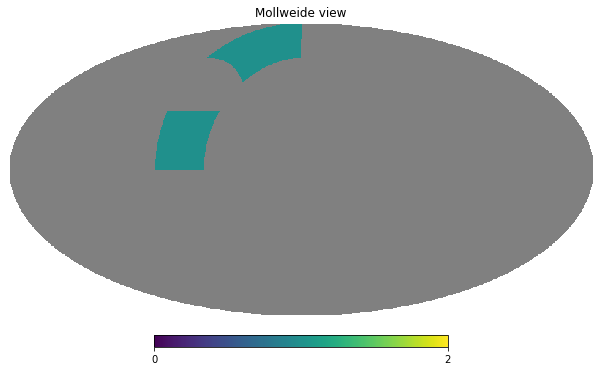

In [74]:
if use_window:
    hp.mollview(zl_bin[0]['window'])

[]

05:16:51 DEBUG:vmin 0.6465185261832657 vmax 9501.661207243844
05:16:51 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:16:51 DEBUG:vmin 7.39789030815191e-13 vmax 0.07722923949494856
05:16:51 DEBUG:ticklocs array([1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01,
       1.e+01])
05:16:51 DEBUG:vmin 0.6465185261832657 vmax 9501.661207243844
05:16:51 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:16:51 DEBUG:vmin 0.6465185261832657 vmax 9501.661207243844
05:16:51 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:16:51 DEBUG:vmin 0.6465185261832657 vmax 9501.661207243844
05:16:51 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e

05:16:51 DEBUG:vmin 7.39789030815191e-13 vmax 0.07722923949494856
05:16:51 DEBUG:ticklocs array([1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01,
       1.e+01])
05:16:51 DEBUG:vmin 7.39789030815191e-13 vmax 0.07722923949494856
05:16:51 DEBUG:ticklocs array([], dtype=float64)
05:16:51 DEBUG:vmin 7.39789030815191e-13 vmax 0.07722923949494856
05:16:51 DEBUG:ticklocs array([1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01,
       1.e+01])
05:16:51 DEBUG:vmin 7.39789030815191e-13 vmax 0.07722923949494856
05:16:51 DEBUG:ticklocs array([1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01,
       1.e+01])
05:16:51 DEBUG:vmin 7.39789030815191e-13 vmax 0.07722923949494856
05:16:51 DEBUG:ticklocs array([], dtype=float64)
05:16:51 DEBUG:vmin 0.6465185261832657 vmax 9501.661207243844
05:16:51 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:16:51 DEBUG:vmin 0.6465185261832657 vmax 9501.661207243844
05:16:51 DEBUG:tick

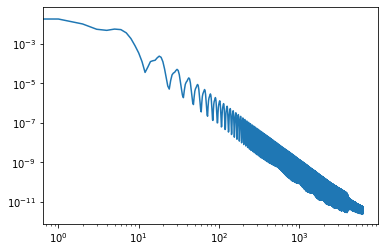

In [75]:
window_cl=hp.anafast(zl_bin[0]['window'])
plt.plot(window_cl)
plt.loglog()

In [76]:
zs_bin=cmb_bins_here(l=l, nside = NSIDE)# lensing source bin

In [77]:
store_win=True

In [78]:
f_sky=0.04404143492380778 #FIXME: use the correct value. If you are using window, then this is not very important.

In [79]:
corr_ll=('kappa','kappa')
corr_gg=('galaxy','galaxy')
corr_gl=('galaxy','kappa')
corrs=[corr_ll, corr_gg, corr_gl]

In [80]:
client

Client Scheduler: inproc://10.0.0.147/61780/1 Dashboard: http://10.0.0.147:8787/status,Cluster Workers: 1 Cores: 4 Memory: 150.00 GB


In [81]:
zmin = 0.1
zmax = 2.45

In [83]:
l0_nowin = l0
#l0_nowin = np.arange(3 * NSIDE)
#use all ell
kappa0_nowin=Skylens(kappa_zbins=zs_bin,do_cov=False,bin_cl=False,l_bins=None,l=l0_nowin, 
                     galaxy_zbins=zl_bin,
                                       use_window=False,Tri_cov=Tri_cov, #Win = win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=np.linspace(zmin,zmax,100))
               #pk_params = {'pk_func' : 'class_pk'})

Tracer utils has tracers:  ['galaxy', 'kappa']
pk_params dict was none, intialized with default
cosmology interpolation range 0.0 2.455
power spectra class_pk
Win gen: step size 45 924 2049.0 1
Window done. Size: 0.0


/home/tkarim/SkyLens/skylens/cov_utils.py:92: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th


In [84]:
#use all ell
kappa0=Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, #Win = win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=np.linspace(zmin,zmax,100))
               #pk_params = {'pk_func' : 'class_pk'})

Tracer utils has tracers:  ['galaxy', 'kappa']
pk_params dict was none, intialized with default
cosmology interpolation range 0.0 2.455
power spectra class_pk
Win gen: step size 45 924 2049.0 1
wigner_files: {0: '../temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 6.222724914550781e-05
set window_cl: cl done 0.0014481544494628906 2365.901 0.0
Win_cli ('kappa', 'kappa', 0, 0) ('kappa', 'kappa') (0, 0)
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
Win_cli ('galaxy', 'kappa', 0, 0) ('galaxy', 'kappa') (0, 0)
set window_cl: cl done 3.655405044555664 2365.901 0.0
cl+cov bags done 3 0 7.786500692367554
set_window_cl done 37.138800382614136
setting windows, coupling matrices  <Client: 'inproc://10.0.0.147/61780/1' processes=1 threads=4, memory=150.00 GB>
doing lm 0
done lm cl+cov graph 0 0.0008373260498046875 3221.588 inproc://10.0.0.147/61780/3
done lm 0 5.118619680404663
doing lm 45
done lm cl+cov graph 45 0.00142478942871

In [85]:
%time cl0G=kappa0.cl_tomo() 
cl0G_nowin=kappa0_nowin.cl_tomo() 

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 20.4 s, sys: 163 ms, total: 20.5 s
Wall time: 9.52 s
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary


In [86]:
#dask.visualize(cl0G['stack'])

In [87]:
lb

array([150., 250., 350., 450., 550., 650., 750., 850., 950.])

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)
/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


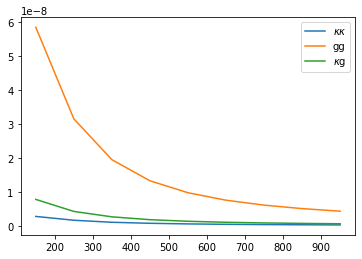

In [88]:
bi=(0,0) #z_bin indexes
plt.plot(lb, cl0G['pseudo_cl_b'][corr_ll][bi].compute(), label = r'$\kappa \kappa$')
plt.plot(lb, cl0G['pseudo_cl_b'][corr_gg][bi].compute(), label = 'gg')
plt.plot(lb, cl0G['pseudo_cl_b'][corr_gl][bi].compute(), label = r'$\kappa$g')

plt.legend(loc = 'best')

In [32]:
cl0G['cl'][corr_gg][bi].compute()

array([1.99280296e-06, 1.97586749e-06, 1.95930043e-06, ...,
       2.31307647e-08, 2.31219447e-08, 2.31131241e-08])

## Test for window effects

In [35]:
NSIDE = 1024
LMAX = 3 * NSIDE

In [89]:
cls_cmb_th = cl0G_nowin['cl'][corr_ll][bi].compute()
cls_elg_th = cl0G_nowin['cl'][corr_gg][bi].compute()
cls_crs_th = cl0G_nowin['cl'][corr_gl][bi].compute()

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


In [90]:
#generate synthetic map using theory Cls
m_k, m_g = hp.synfast((cls_cmb_th, cls_crs_th, cls_elg_th), NSIDE, lmax=LMAX-1, pol=False, verbose=False)

05:32:40 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f7ae873bd00>
05:32:40 DEBUG:Using fixed locator on colorbar
05:32:40 DEBUG:Setting pcolormesh


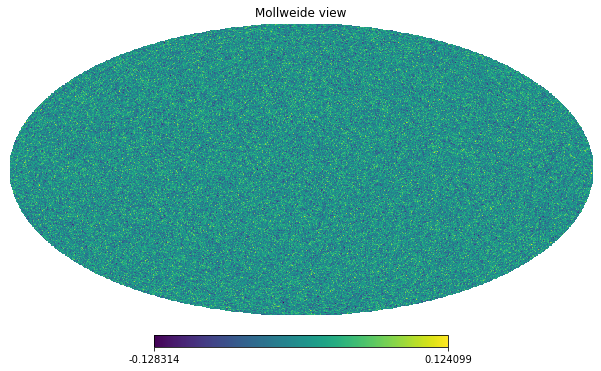

In [91]:
hp.mollview(m_k)

05:32:42 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f7ae86f64f0>
05:32:42 DEBUG:Using fixed locator on colorbar
05:32:42 DEBUG:Setting pcolormesh


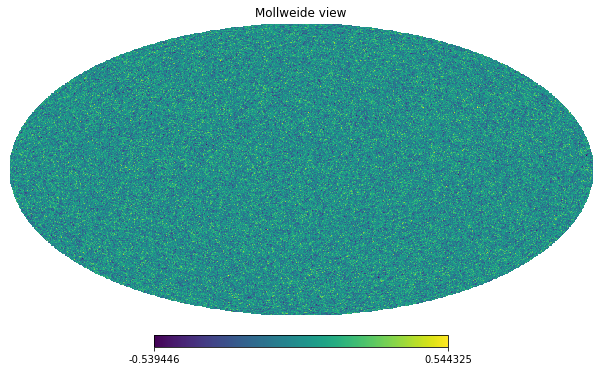

In [92]:
hp.mollview(m_g)

05:32:46 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f7ae86bdc10>
05:32:46 DEBUG:Using fixed locator on colorbar
05:32:46 DEBUG:Setting pcolormesh


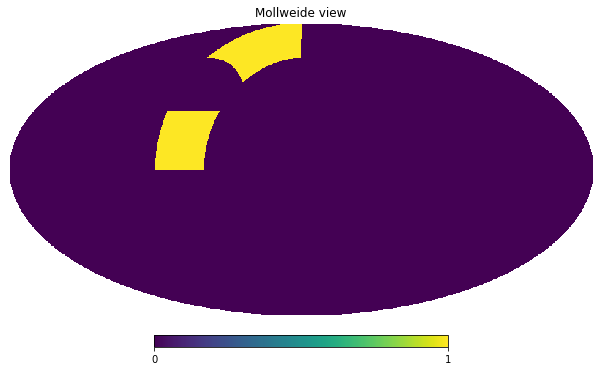

In [93]:
mask_abacus = np.load("/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_ring_2048.npy")
mask_abacus = hp.ud_grade(mask_abacus, 1024, power = -2)
hp.mollview(mask_abacus)

In [94]:
#cmb lensing
kappa_masked = hp.ma(m_k)
kappa_masked.mask = np.logical_not(mask_abacus)

#elg
elg_masked = hp.ma(m_g)
elg_masked.mask = np.logical_not(mask_abacus)

05:32:47 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f7ae864fc10>
05:32:47 DEBUG:Using fixed locator on colorbar
05:32:47 DEBUG:Setting pcolormesh


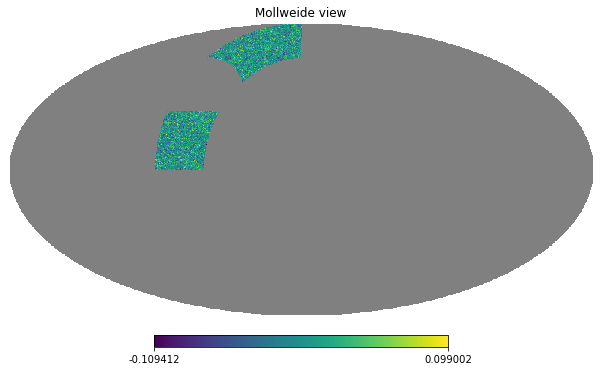

In [95]:
hp.mollview(kappa_masked)

05:32:47 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f7ae85dfdf0>
05:32:47 DEBUG:Using fixed locator on colorbar
05:32:47 DEBUG:Setting pcolormesh


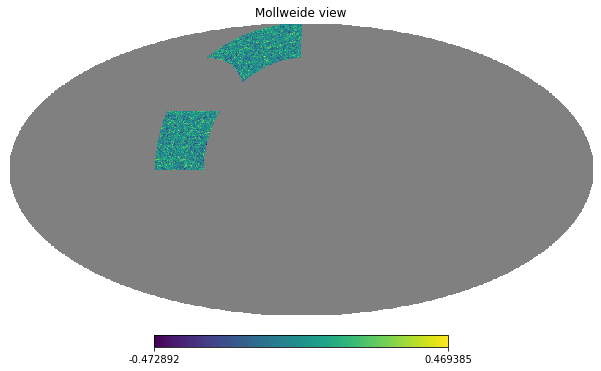

In [96]:
hp.mollview(elg_masked)

In [97]:
#calculate Cls

#auto spectra
clkk_syn = hp.anafast(kappa_masked, lmax = LMAX - 1, pol = False)
clgg_syn = hp.anafast(elg_masked, lmax = LMAX - 1, pol = False)

#cross spectra
clkg_syn = hp.anafast(kappa_masked, elg_masked, lmax = LMAX - 1, pol = False)

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


05:35:11 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:11 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:35:11 DEBUG:vmin 1.2448457276582626e-14 vmax 9.988728078819336e-09
05:35:11 DEBUG:ticklocs array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
       1.e-07])
05:35:11 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:11 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:35:11 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:11 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:35:11 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:11 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e

05:35:12 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:12 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:35:12 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:12 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:35:12 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:12 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
05:35:12 DEBUG:vmin 0.6693

05:35:12 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:12 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:35:12 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:12 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
05:35:12 DEBUG:vmin 0.6693234010469284 vmax 4588.2154952246765
05:35:12 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
05:35:12 DEBUG:vmin 0.6693

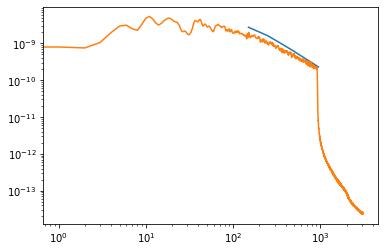

In [100]:
#plt.loglog(cls_cmb_th * f_sky, label = 'Theory')
plt.loglog(lb, cl0G['pseudo_cl_b'][corr_ll][bi].compute())
plt.loglog(np.arange(LMAX),clkk_syn, label = 'Gaussian Sim')

Compare with Abacus

In [22]:
cL_abacus = np.array([2.98436168e-09, 1.59208922e-09, 1.02584562e-09, 6.76985059e-10,
       5.34959849e-10, 4.01468676e-10, 3.29359846e-10, 2.69317428e-10,
       2.32066641e-10])

bi=(0,0)
cL_skylens = cl0G['pseudo_cl_b'][corr_ll][bi].compute()
#cov from skylens
cov_skylens = cl0G['cov'][corr_ll+corr_ll][bi+bi].compute()['final_b']

NameError: name 'cl0G' is not defined

In [21]:
plt.figure(figsize = (10,8))
#err = np.sqrt(np.diag(cov_skylens))
#plt.errorbar(lb, cL_abacus, yerr = err, label = 'abacus')
plt.plot(lb, cL_skylens, label = 'skylens')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc= 'best')

NameError: name 'cL_skylens' is not defined

<Figure size 720x576 with 0 Axes>

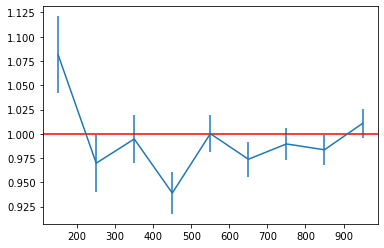

In [29]:
plt.errorbar(lb, cL_abacus/cL_skylens, yerr = err/cL_skylens)
plt.axhline(1, c = 'red')

In [30]:
loss = (cL_abacus - cL_skylens)
inv = np.linalg.inv(cov_skylens)
chi2 = loss @ inv @ loss

In [31]:
chi2

17.679574745241027

In [32]:
corrmat = cov_skylens/np.outer(err, err)

07:10:54 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f52abf9b970>
07:10:54 DEBUG:Using auto colorbar locator on colorbar
07:10:54 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f52abf9b970>
07:10:54 DEBUG:Setting pcolormesh


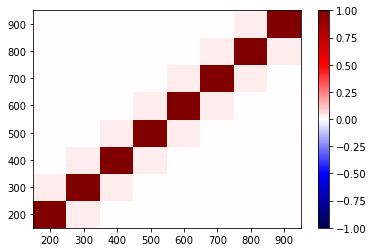

In [33]:
plt.pcolor(lb, lb, corrmat, vmin = -1, vmax = 1, cmap = 'seismic')
plt.colorbar()
#plt.xscale('log')
#plt.yscale('log')